In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cloudpickle
import base64
import pickle
import boto3
import json
import numpy as np
from datetime import datetime
from functools import partial
from dask.local import get_async
from dask import bag as db
import concurrent

In [3]:
import logging
logger = logging.getLogger(name='lambda')
logger.setLevel(logging.INFO)
logging.debug("test")

### invocation wrapper

In [16]:
def invoke_with_lambda(
        func,
        lambda_client = boto3.client('lambda'),
    ):
    logger.debug(f'invoking lambda {func}')
    lambda_pickled = cloudpickle.dumps(func)
    lambda_base64 = base64.encodebytes(lambda_pickled)
    lambda_str = lambda_base64.decode('utf-8')
    lambda_json = json.dumps(lambda_str)
    logger.debug(lambda_json)
    response = lambda_client.invoke(
          FunctionName='sprite',
          Payload=lambda_json,
    )
    response_bytes = response['Payload'].read()
    response_str = response_bytes.decode('utf-8')
    response_json = json.loads(response_str)
    result_bytes = response_json.encode('utf8')
    result_pkl = base64.decodebytes(result_bytes)
    result = pickle.loads(result_pkl)
    logger.debug(f'receiving result {result}')
    return result

In [5]:
# dask specific stuff
num_workers = 100
executor = concurrent.futures.ThreadPoolExecutor(max_workers=num_workers)

def apply_async_lambda(func, args=(), kwds={}, callback=None):
    def doit():
        res = invoke_with_lambda(lambda: func(*args, **kwds))
        if callback is not None:
            callback(res)
    executor.submit(doit)

def get_async_lambda(dsk, keys, **kwargs):
    """A naive synchronous version of get_async
    Can be useful for debugging.
    """
    return get_async(apply_async_lambda, num_workers, dsk, keys, **kwargs)

### call some functions remotely

In [17]:
logger.setLevel(logging.DEBUG)

In [6]:
hello_print = lambda o: f'this executes {o}'

In [7]:
hello_print('locally')

'this executes locally'

In [18]:
invoke_with_lambda(partial(hello_print, 'remotely'))

DEBUG:lambda:invoking lambda functools.partial(<function <lambda> at 0x1095678c8>, 'remotely')
DEBUG:lambda:"gASVaQEAAAAAAACMCWZ1bmN0b29sc5SMB3BhcnRpYWyUk5SMF2Nsb3VkcGlja2xlLmNsb3VkcGlj\na2xllIwOX2ZpbGxfZnVuY3Rpb26Uk5QoaAOMD19tYWtlX3NrZWxfZnVuY5STlGgDjA1fYnVpbHRp\nbl90eXBllJOUjAhDb2RlVHlwZZSFlFKUKEsBSwBLAUsCS0NDCmQBfACbAJ0CUwCUTowOdGhpcyBl\neGVjdXRlcyCUhpQpjAFvlIWUjB48aXB5dGhvbi1pbnB1dC02LTA0ZTQwZGE4YjQ1NT6UjAg8bGFt\nYmRhPpRLAUMAlCkpdJRSlEr/////fZSHlFKUfZQojAdnbG9iYWxzlH2UjAhkZWZhdWx0c5ROjARk\naWN0lH2UjAZtb2R1bGWUjAhfX21haW5fX5SMDmNsb3N1cmVfdmFsdWVzlE6MCHF1YWxuYW1llGgT\ndXRShZRSlChoGYwIcmVtb3RlbHmUhZR9lE50lGIu\n"
DEBUG:lambda:receiving result this executes remotely


'this executes remotely'

In [9]:
a = np.arange(10)
def squareit():
    return a**a

In [10]:
squareit()

array([        1,         1,         4,        27,       256,      3125,
           46656,    823543,  16777216, 387420489])

In [11]:
%time invoke_with_lambda(squareit)

CPU times: user 3.48 ms, sys: 782 µs, total: 4.26 ms
Wall time: 34.2 ms


array([        1,         1,         4,        27,       256,      3125,
           46656,    823543,  16777216, 387420489])

In [12]:
%timeit invoke_with_lambda(squareit)

34.7 ms ± 2.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## do some dask stuff

In [13]:
b = db.range(100, npartitions=10)
bsum = b.sum()

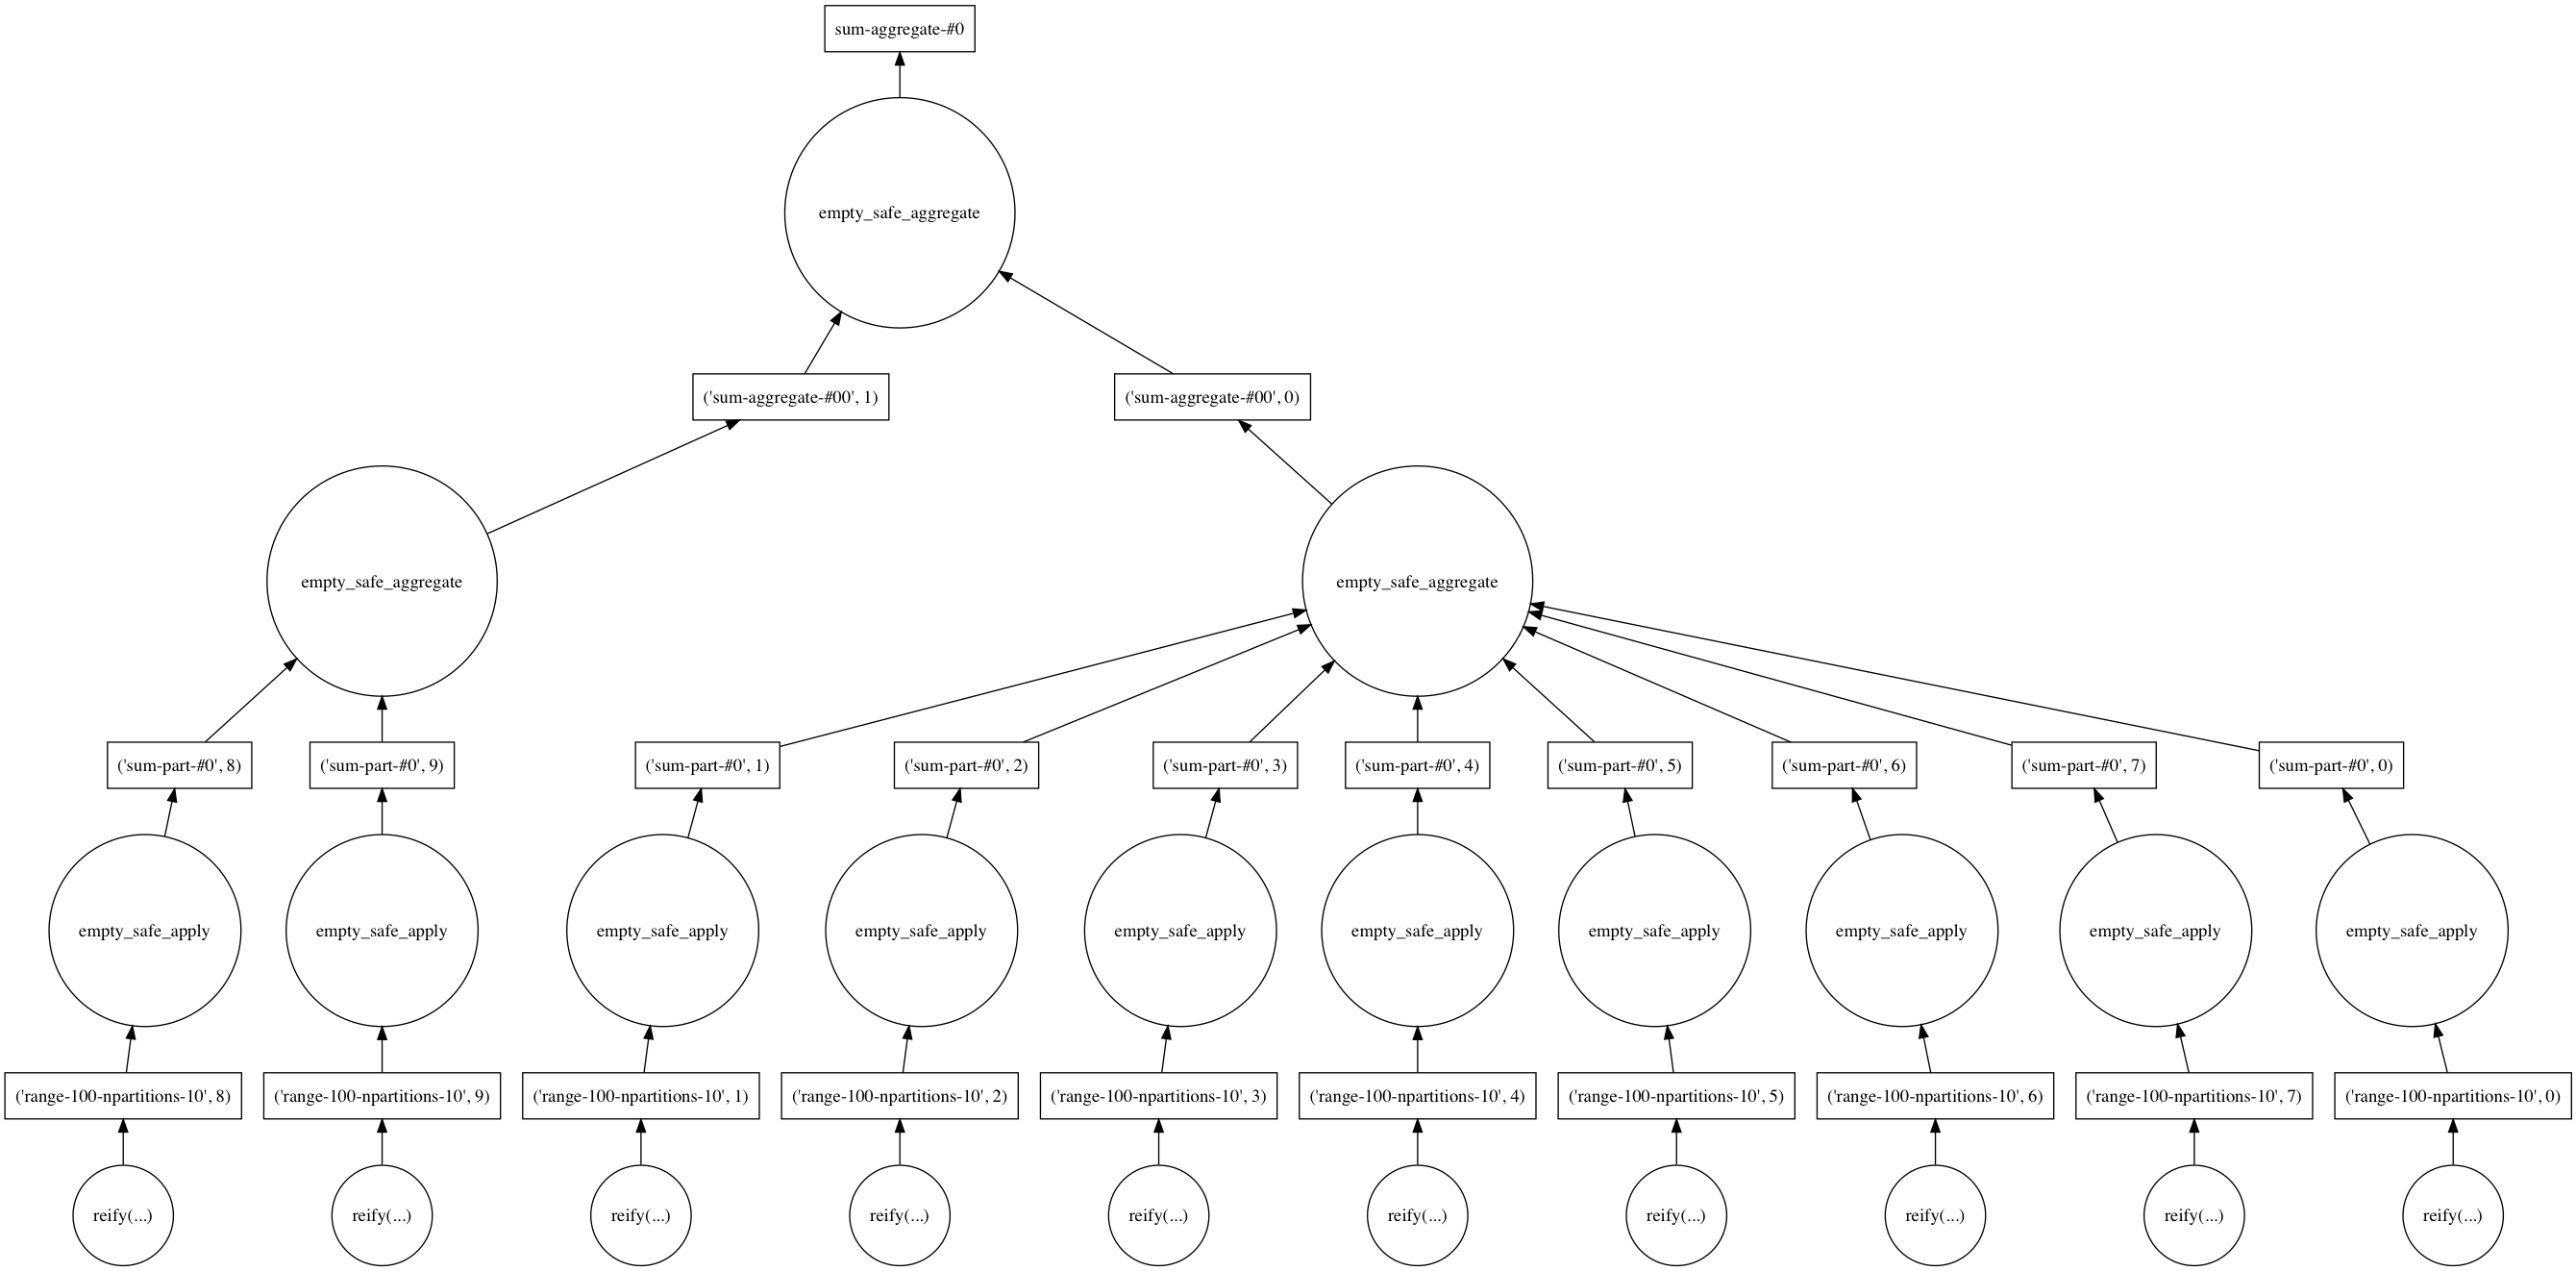

In [14]:
bsum.visualize()

In [15]:
logger.setLevel(logging.DEBUG)
%time bsum.compute(get=get_async_lambda)
logger.setLevel(logging.INFO)

DEBUG:lambda:invoking lambda <function apply_async_lambda.<locals>.doit.<locals>.<lambda> at 0x10a024840>
DEBUG:lambda:invoking lambda <function apply_async_lambda.<locals>.doit.<locals>.<lambda> at 0x10a024ae8>
DEBUG:lambda:invoking lambda <function apply_async_lambda.<locals>.doit.<locals>.<lambda> at 0x10a024e18>
DEBUG:lambda:invoking lambda <function apply_async_lambda.<locals>.doit.<locals>.<lambda> at 0x10a024ea0>
DEBUG:lambda:invoking lambda <function apply_async_lambda.<locals>.doit.<locals>.<lambda> at 0x10a024f28>
DEBUG:lambda:invoking lambda <function apply_async_lambda.<locals>.doit.<locals>.<lambda> at 0x10a09f2f0>
DEBUG:lambda:invoking lambda <function apply_async_lambda.<locals>.doit.<locals>.<lambda> at 0x10a09f488>
DEBUG:lambda:invoking lambda <function apply_async_lambda.<locals>.doit.<locals>.<lambda> at 0x10a09f620>
DEBUG:lambda:invoking lambda <function apply_async_lambda.<locals>.doit.<locals>.<lambda> at 0x10a09fa60>
DEBUG:lambda:invoking lambda <function apply_a

CPU times: user 232 ms, sys: 38.3 ms, total: 270 ms
Wall time: 344 ms
